In [1]:
import math
import scipy
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot;
from skimage.color import *

%matplotlib inline
from pylab import *

from skimage import *
from skimage.transform import *
from skimage.filters import *
from skimage.feature import *
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation

from scipy.ndimage import *
from copy import deepcopy

# Segmenatcija slike

Ideja segmentacije je da se izdvoji deo slike u kom se nalaze linije koje razdvajaju saobraćajne trake. Ideja je da se izdvoje delovi slike koji sadrže žutu(Slika 1) i belu(Slika 2) boju. Pošto bele saobraćajne trake ne zauzimaju veliku površinu slike izvojeni su beli objekti koji zauzimaju veliku površinu(Slika 3) i oni se uklanjaju sa binarizovane slike belih delova slike(Slika 4), potom se spajaju binarizovane slike žutih i belih delova slike(Slika 5) i sa ove slike su uklonjeni delovi koji ne zauzimaju veliku površinu i naglašeni su preostali delovi(Slika 6).

In [2]:
def segment_lanes(im):
    im_hsv = rgb2hsv(im);
    im_bin1 = np.zeros((im.shape[0],im.shape[1]));
    im_bin2 = np.zeros((im.shape[0],im.shape[1]));
    im_bin1[(im_hsv[:,:,0]<0.15)*(im_hsv[:,:,1]>0.25)*(im_hsv[:,:,1]<0.9)*(im_hsv[:,:,2]>0.85)] = 1;
    im_bin2[(im_hsv[:,:,0]<0.4)*(im_hsv[:,:,1]<0.15)*(im_hsv[:,:,2]>0.85)] = 1;
    res1 = binary_erosion(im_bin2,np.ones((15,15)))
    res11 = binary_dilation(res1,np.ones((60,60)));
    im_bin2 -= res11;
    im_bin1[im_bin2==1] = 1;
    res3 = binary_erosion(im_bin1,np.ones((3,3)))
    res4 = binary_dilation(res3,np.ones((5,5)));
    return res4;

In [3]:
def segment_lanes_plot(im):
    fix, axes = plt.subplots(2, 3, figsize=(18, 8));
    ax = axes.ravel()
    im_hsv = rgb2hsv(im);
    im_bin1 = np.zeros((im.shape[0],im.shape[1]));
    im_bin2 = np.zeros((im.shape[0],im.shape[1]));
    im_bin1[(im_hsv[:,:,0]<0.15)*(im_hsv[:,:,1]>0.25)*(im_hsv[:,:,1]<0.9)*(im_hsv[:,:,2]>0.85)] = 1;
    ax[0].imshow(im_bin1,cmap='gray');
    im_bin2[(im_hsv[:,:,0]<0.4)*(im_hsv[:,:,1]<0.15)*(im_hsv[:,:,2]>0.85)] = 1;
    ax[1].imshow(im_bin2,cmap='gray');
    res1 = binary_erosion(im_bin2,np.ones((15,15)))
    res11 = binary_dilation(res1,np.ones((60,60)));
    ax[2].imshow(res11,cmap='gray');
    im_bin2 -= res11;
    im_bin2[im_bin2<0]=0;
    ax[3].imshow(im_bin2,cmap='gray');
    im_bin1[im_bin2==1] = 1;
    ax[4].imshow(im_bin1,cmap='gray');
    res3 = binary_erosion(im_bin1,np.ones((3,3)))
    res4 = binary_dilation(res3,np.ones((5,5)));
    ax[5].imshow(res4,cmap='gray');
    for i in range(0,6):
        ax[i].axis('off');
        ax[i].set_title('Slika '+str(i+1));
    plt.show();
    return res4;

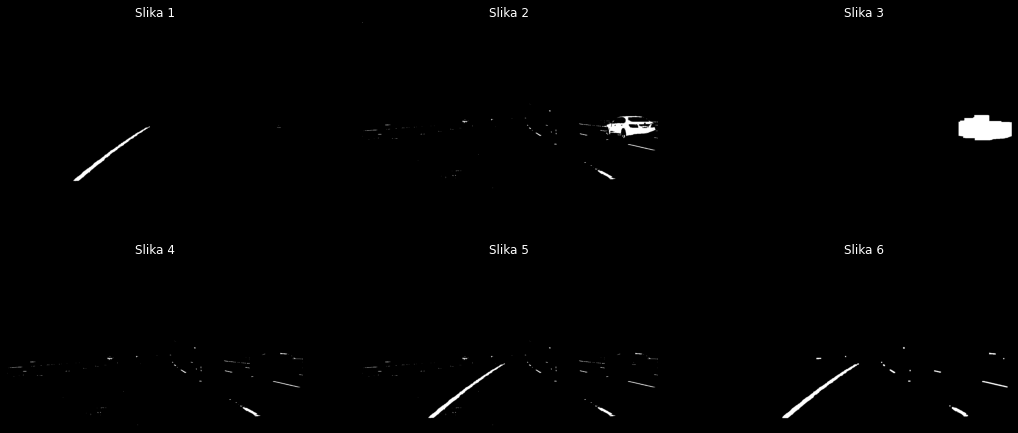

In [33]:
im = imread('test_frames/test1.jpg');
segment_lanes_plot(im);

In [5]:
def get_line_segment(img_edges, line, min_size, max_gaps, tolerancy):
    res = np.empty([0,4]);
    if(line[0]<math.pi/4 or line[0]>3*math.pi/4):
        #print('a');
        points = np.zeros((img_edges.shape[1]))-1
        for i in range(0,img_edges.shape[1]):
            x = round(line[1]/math.cos(line[0]) - i*math.tan(line[0]));
            if (x<0 or x>=img_edges.shape[0]):
                continue;
            xn = sum((img_edges[(int(x-tolerancy/2) if (x-tolerancy/2>0) else 0):(int(x+tolerancy/2) if x+tolerancy/2<img_edges.shape[0]-1 else img_edges.shape[0]-1),
            (int(i-tolerancy/2) if (i-tolerancy/2>0) else 0):(int(i+tolerancy/2) if i+tolerancy/2<img_edges.shape[1]-1 else img_edges.shape[1]-1)]).flatten());
            points[i] = (1 if (xn>0) else 0);
        first = -1; last = -1;
        for i in range(0,img_edges.shape[1]):
            if(points[i]==1):
                if(first==-1):
                    first=i;
                last=i;
            else:
                if((i-last)==max_gaps):
                    if(last-first>=min_size):
                        res = np.append(res,[[round(line[1]/math.cos(line[0]) - first*math.tan(line[0])),first,round(line[1]/math.cos(line[0]) - last*math.tan(line[0])),last]],axis=0);
                    first = -1;
                    last = -1;
        if(last-first>=min_size):
            res = np.append(res,[[round(line[1]/math.cos(line[0]) - first*math.tan(line[0])),first,round(line[1]/math.cos(line[0]) - last*math.tan(line[0])),last]],axis=0);
    else:
        points = np.zeros((img_edges.shape[0]))-1;
        for i in range(0,img_edges.shape[0]):
            y = round(line[1]/math.sin(line[0]) - i/math.tan(line[0]));
            if (y<0 or y>=img_edges.shape[1]):
                continue;
            yn = sum((img_edges[(int(i-tolerancy/2) if (i-tolerancy/2>0) else 0):(int(i+tolerancy/2) if i+tolerancy/2<img_edges.shape[0]-1 else img_edges.shape[0]-1),
            (int(y-tolerancy/2) if (y-tolerancy/2>0) else 0):(int(y+tolerancy/2) if y+tolerancy/2<img_edges.shape[1]-1 else img_edges.shape[1]-1)]).flatten());
            points[i] = (1 if (yn>0) else 0);
        first = -1; last = -1;
        for i in range(0,img_edges.shape[0]):
            if(points[i]==1):
                if(first==-1):
                    first=i;
                last=i;
            else:
                if((i-last)==max_gaps):
                    if(last-first>=min_size):
                        res = np.append(res,[[first,round(line[1]/math.sin(line[0]) - first/math.tan(line[0])),last,round(line[1]/math.sin(line[0]) - last/math.tan(line[0]))]],axis=0);
                    first = -1;
                    last = -1;
        if(last-first>=min_size):
            res = np.append(res,[[first,round(line[1]/math.sin(line[0]) - first/math.tan(line[0])),last,round(line[1]/math.sin(line[0]) - last/math.tan(line[0]))]],axis=0);
    return res;

In [18]:
def canny_edge_detection(img_in, sigma, threshold_low, threshold_high):
    img_in_filt = gaussian(img_in,sigma,truncate=3);
    Hx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    Hy = np.transpose(Hx)
    Gx = scipy.ndimage.correlate(img_in_filt, Hx, mode='nearest')
    Gy = scipy.ndimage.correlate(img_in_filt, Hy, mode='nearest')
    mag = np.sqrt(np.square(Gx) + np.square(Gy))
    angle = np.rad2deg(np.arctan2(Gy, Gx))
    angle[(angle>=-157.5)&(angle<-112.5)]=45;
    angle[(angle>=-112.5)&(angle<-67.5)]=90;
    angle[(angle>=-67.5)&(angle<-22.5)]=-45;
    angle[(angle>=-22.5)&(angle<22.5)]=0;
    angle[(angle>=22.5) &(angle<67.5)]=45;
    angle[(angle>=67.5) &(angle<112.5)]=90;
    angle[(angle>=112.5)&(angle<157.5)]=-45;
    angle[(angle>=157.5)|(angle<-157.5)]=0;

    max0 = mag - maximum_filter(mag,footprint=[[0,1,0],[0,1,0],[0,1,0]]);
    max90 = mag - maximum_filter(mag,footprint=[[0,0,0],[1,1,1],[0,0,0]]);
    max45 = mag - maximum_filter(mag,footprint=[[1,0,0],[0,1,0],[0,0,1]]);
    max_45 = mag - maximum_filter(mag,footprint=[[0,0,1],[0,1,0],[1,0,0]]);
    max0[max0==0] = 1;
    max0[max0<0] = 0;
    max90[max90==0] = 1;
    max90[max90<0] = 0;
    max45[max45==0] = 1;
    max45[max45<0] = 0;
    max_45[max_45==0] = 1;
    max_45[max_45<0] = 0;

    loc_max = np.zeros_like(mag);
    loc_max[(angle==0) & (max0==1)] = mag[(angle==0) & (max0==1)];
    loc_max[(angle==45) & (max45==1)] = mag[(angle==45) & (max45==1)];
    loc_max[(angle==90) & (max90==1)] = mag[(angle==90) & (max90==1)];
    loc_max[(angle==-45) & (max_45==1)] = mag[(angle==-45) & (max_45==1)];

    thr_high = np.zeros_like(loc_max);
    thr_high[loc_max>=threshold_high] = 1;
    thr_low = np.zeros_like(loc_max);
    thr_low[loc_max>=threshold_low] = 1;
    for i in range(0,200):
        thr_high = thr_low*maximum_filter(thr_high,footprint=[[1,1,1],[1,1,1],[1,1,1]])
    
    return thr_high;

In [27]:
def canny_edge_detection_plot(img_in, sigma, threshold_low, threshold_high):
    fix, axes = plt.subplots(2,5, figsize=(32, 8));
    ax = axes.ravel();
    img_in_filt = gaussian(img_in,sigma,truncate=3);
    ax[0].imshow(img_in_filt,cmap='gray');
    ax[0].set_title('Posle filtra');
    Hx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    Hy = np.transpose(Hx)
    Gx = scipy.ndimage.correlate(img_in_filt, Hx, mode='nearest')
    Gy = scipy.ndimage.correlate(img_in_filt, Hy, mode='nearest')
    ax[1].imshow(Gx,cmap='gray');
    ax[1].set_title('Vertikalni gradijenti');
    ax[2].imshow(Gy,cmap='gray');
    ax[2].set_title('Horizontalni gradijenti');
    mag = np.sqrt(np.square(Gx) + np.square(Gy))
    angle = np.rad2deg(np.arctan2(Gy, Gx))
    ax[3].imshow(mag,cmap='gray');
    ax[3].set_title('Magnitude gradijenata');
    ax[4].imshow(angle,cmap='gray');
    ax[4].set_title('Uglovi gradijenata');
    angle[(angle>=-157.5)&(angle<-112.5)]=45;
    angle[(angle>=-112.5)&(angle<-67.5)]=90;
    angle[(angle>=-67.5)&(angle<-22.5)]=-45;
    angle[(angle>=-22.5)&(angle<22.5)]=0;
    angle[(angle>=22.5) &(angle<67.5)]=45;
    angle[(angle>=67.5) &(angle<112.5)]=90;
    angle[(angle>=112.5)&(angle<157.5)]=-45;
    angle[(angle>=157.5)|(angle<-157.5)]=0;
    ax[5].imshow(angle,cmap='gray');
    ax[5].set_title('Kvantizovani uglovi gradijenata');

    max0 = mag - maximum_filter(mag,footprint=[[0,1,0],[0,1,0],[0,1,0]]);
    max90 = mag - maximum_filter(mag,footprint=[[0,0,0],[1,1,1],[0,0,0]]);
    max45 = mag - maximum_filter(mag,footprint=[[1,0,0],[0,1,0],[0,0,1]]);
    max_45 = mag - maximum_filter(mag,footprint=[[0,0,1],[0,1,0],[1,0,0]]);
    max0[max0==0] = 1;
    max0[max0<0] = 0;
    max90[max90==0] = 1;
    max90[max90<0] = 0;
    max45[max45==0] = 1;
    max45[max45<0] = 0;
    max_45[max_45==0] = 1;
    max_45[max_45<0] = 0;

    loc_max = np.zeros_like(mag);
    loc_max[(angle==0) & (max0==1)] = mag[(angle==0) & (max0==1)];
    loc_max[(angle==45) & (max45==1)] = mag[(angle==45) & (max45==1)];
    loc_max[(angle==90) & (max90==1)] = mag[(angle==90) & (max90==1)];
    loc_max[(angle==-45) & (max_45==1)] = mag[(angle==-45) & (max_45==1)];
    ax[6].imshow(loc_max,cmap='gray');
    ax[6].set_title('Lokalni maksimumi gradijenata');

    thr_high = np.zeros_like(loc_max);
    thr_high[loc_max>=threshold_high] = 1;
    ax[7].imshow(thr_high,cmap='gray');
    ax[7].set_title('Jake ivice');
    thr_low = np.zeros_like(loc_max);
    thr_low[loc_max>=threshold_low] = 1;
    ax[8].imshow(thr_low,cmap='gray');
    ax[8].set_title('Slabe ivice');
    for i in range(0,200):
        thr_high = thr_low*maximum_filter(thr_high,footprint=[[1,1,1],[1,1,1],[1,1,1]])

    ax[9].imshow(thr_high,cmap='gray');
    ax[9].set_title('Rezultat filtra');
    for i in range(0,10):
        ax[i].axis('off');
    show();
    return thr_high;

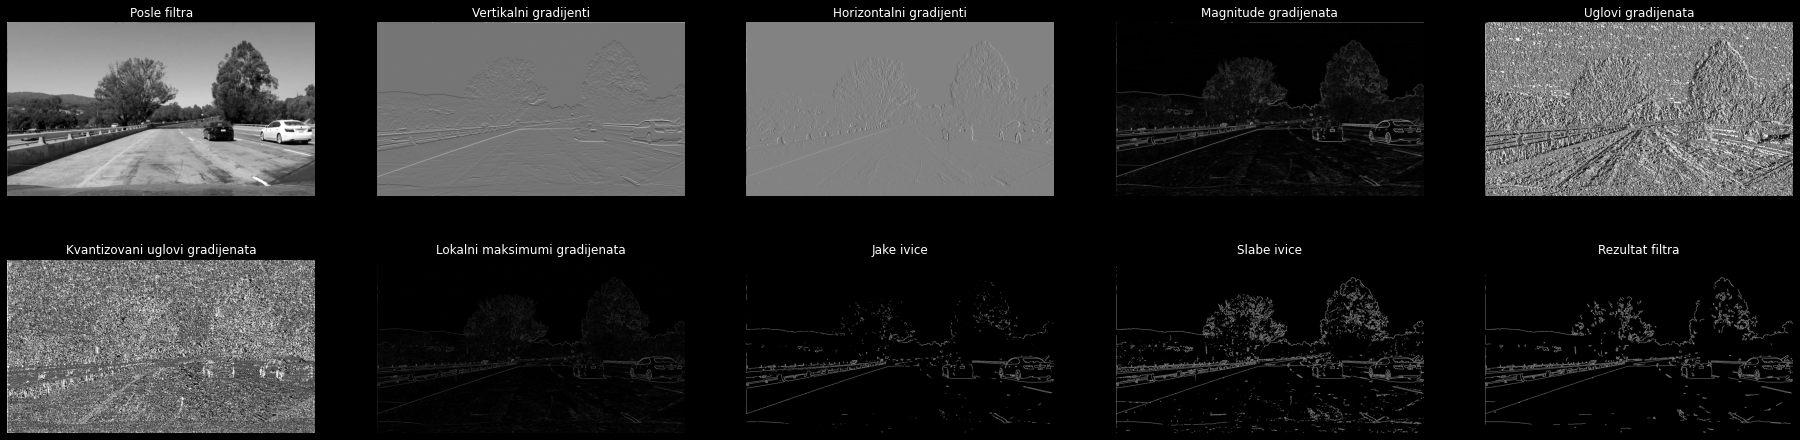

In [32]:
im = imread('test_frames/test1.jpg');
canny_edge_detection_plot(rgb2gray(im), 0.1, 0.5, 1);
show()

# Detekcija linija koje razdvajaju saobraćajne trake

Hafova transformacija je posebno rađena za desnu liniju i posebno za levu liniju koja razdvaja saobraćajne trake. Za levu liniju je rađena transformacija za uglove od 0 do pi/4, dok je za desnu rađena za uglove -0.35*pi do -0.15*pi, ukoliko se ne pronađe ni jedan pravac u ovom opsegu traže se pravac u opsegu od -pi/2 do -0.1*pi. Ugrađena funkcija hough_line posmatra uglove u odnosu na y osu slike, dok su ovi uglovi definisani u odnosu na x osu slike. Među 10 pravaca koji imaju najveću vrednost pri Hafovoj transformaciji za pravac na kojem se nalazi linija koja razdvaja saobraćajne trake se uzima ona koja ima dajdužu liniju na svom pravcu, ovo se određuje posebno za levu i posebno za desnu liniju. Za ovo se koristi prethodno implementirana funkcija get_line_segment.

In [7]:
def lane_detection(im):
    im1 = segment_lanes(im);
    im2 = canny_edge_detection(im1, 0.1, 0.5, 1);
    theta = np.linspace(1.3*pi/2,pi,1000)
    [a,b,c] = hough_line(im2,theta=theta);#,theta=theta);
    [a1,b1,c1] = hough_line_peaks(a,b,c,num_peaks=10);
    max_lenr = 0;
    thetar = -1;
    rhor = -1;
    laner=[-1,-1,-1,-1];
    for i in range(0,a1.shape[0]):
        res = get_line_segment(im2, [pi/2-b1[i],c1[i]], 10, 5, 10);
        for ii in range(0,res.shape[0]):
            length = math.sqrt((res[ii,1]-res[ii,3])**2+(res[ii,0]-res[ii,2])**2);
            if (length>max_lenr):
                max_lenr = length;
                thetar = pi/2-b1[i];
                rhor = c1[i];
                laner = res[ii,:];

    theta = np.linspace(pi/4,pi/2,1000)
    [a,b,c] = hough_line(im2,theta=theta);
    [a1,b1,c1] = hough_line_peaks(a,b,c,num_peaks=10);
    max_lenl = 0;
    thetal = -1;
    rhol = -1;
    lanel=[-1,-1,-1,-1];
    for i in range(0,a1.shape[0]):
        res = get_line_segment(im2, [pi/2-b1[i],c1[i]], 10, 5, 10);
        for ii in range(0,res.shape[0]):
            length = math.sqrt((res[ii,1]-res[ii,3])**2+(res[ii,0]-res[ii,2])**2);
            if (length>max_lenl):
                max_lenl = length;
                thetal = pi/2-b1[i];
                rhol = c1[i];
                lanel = res[ii,:];
    return np.append(lanel[np.newaxis,...],laner[np.newaxis,...],axis=0);

In [ ]:
video = imageio.get_reader("../sekvence/video_road.mp4")
metadata = video.get_meta_data()

writer = imageio.get_writer('video_road_output.mp4', fps=metadata['fps'])
for j,im in enumerate(video):
    res = lane_detection(im);
    a0 = (res[0,1]-res[0,3])/(res[0,0]-res[0,2]);
    b0 = res[0,1] - res[0,0]*a0;
    a1 = (res[1,1]-res[1,3])/(res[1,0]-res[1,2]);
    b1 = res[1,1] - res[1,0]*a1;
    im1 = deepcopy(im);
    for i in range(math.floor(im.shape[0]/2),im.shape[0]):
        if(math.floor(a0*i+b0)-3<0):
            continue;
        if(math.floor(a0*i+b0)+3>im.shape[1]):
            continue;
        im1[i,math.floor(a0*i+b0)-3:math.floor(a0*i+b0)+3,:]=np.zeros((6,3));
    for i in range(math.floor(im.shape[0]/2),im.shape[0]):
        if(math.floor(a1*i+b1)-3<0):
            continue;
        if(math.floor(a1*i+b1)+3>im.shape[1]):
            continue;
        im1[i,math.floor(a1*i+b1)-3:math.floor(a1*i+b1)+3,:]=np.zeros((6,3));
    writer.append_data(im1)
writer.close()

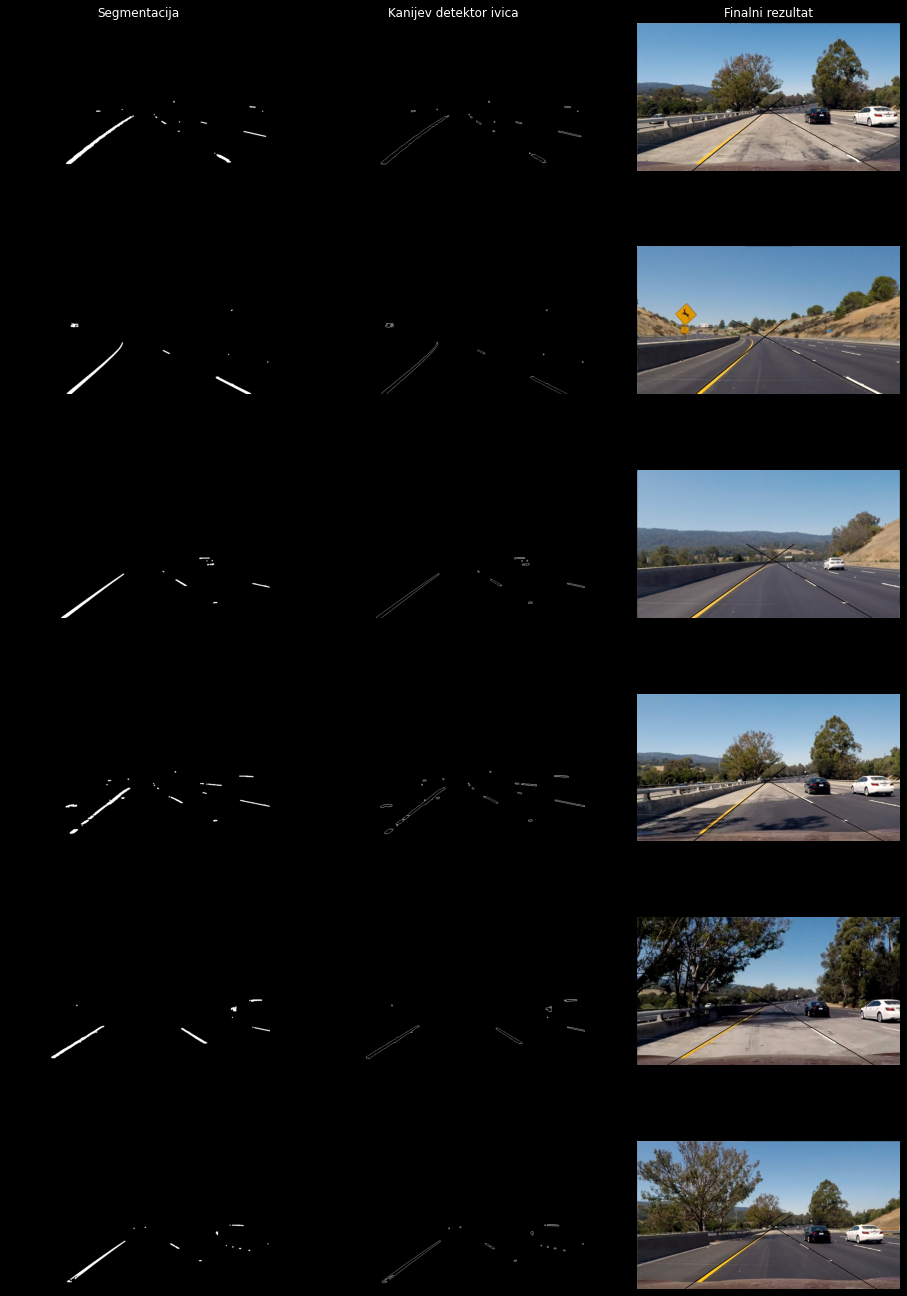

In [31]:
fix, axes = plt.subplots(6, 3, figsize=(16, 24));
ax = axes.ravel()
ax[0].set_title('Segmentacija');
ax[1].set_title('Kanijev detektor ivica');
ax[2].set_title('Finalni rezultat');
for i in range(0,18):
    ax[i].axis('off');
for ii in range(0,6):
    im = imread('test_frames/test'+str(ii+1)+'.jpg');
    segm = segment_lanes(im);
    edges = canny_edge_detection(segm, 0.1, 0.5, 1);
    ax[ii*3].imshow(segm,cmap='gray');
    ax[ii*3+1].imshow(edges,cmap='gray');
    res = lane_detection(im);
    a0 = (res[0,1]-res[0,3])/(res[0,0]-res[0,2]);
    b0 = res[0,1] - res[0,0]*a0;
    a1 = (res[1,1]-res[1,3])/(res[1,0]-res[1,2]);
    b1 = res[1,1] - res[1,0]*a1;
    im1 = deepcopy(im);
    for i in range(math.floor(im.shape[0]/2),im.shape[0]):
        if(math.floor(a0*i+b0)-3<0):
            continue;
        if(math.floor(a0*i+b0)+3>im.shape[1]):
            continue;
        im1[i,math.floor(a0*i+b0)-3:math.floor(a0*i+b0)+3,:]=np.zeros((6,3));
    for i in range(math.floor(im.shape[0]/2),im.shape[0]):
        if(math.floor(a1*i+b1)-3<0):
            continue;
        if(math.floor(a1*i+b1)+3>im.shape[1]):
            continue;
        im1[i,math.floor(a1*i+b1)-3:math.floor(a1*i+b1)+3,:]=np.zeros((6,3));
    ax[ii*3+2].imshow(im1);
show()